In [1]:
import pathlib

import pandas as pd
import altair as alt
from altair import datum

alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
dfs = []
for p in pathlib.Path("results/benchmarks").glob("*.csv"):
    df = (
        pd.read_csv(p)
#         .iloc[:, 1:]
#         .rename_axis("trial")
#         .reset_index()
#         .melt(id_vars="trial", var_name="metric", value_name="seconds")
        .assign(case=p.stem)
        .set_index(["case", "trial"], drop=True)
    )
    dfs.append(df)

In [3]:
df = pd.concat(dfs)

# delta_cols = df.columns[df.columns.str.startswith("initial-")].str.replace("initial-", "delta-")
initial = df.iloc[:, df.columns.str.startswith("initial-")].rename(columns=lambda c: c.replace("initial-", "delta-"))
final = df.iloc[:, df.columns.str.startswith("final-")].rename(columns=lambda c: c.replace("final-", "delta-"))
df = pd.concat([df, final - initial], axis="columns")

df

elapsed    user  nice  system    idle  \
case                       trial                                             
purepy-shuffle-nogc        0       72.444557   68.76   0.0    3.00  220.41   
                           1       74.297284   71.19   0.0    2.30  225.87   
                           2       77.643002   74.66   0.0    2.50  235.44   
                           3       80.859261   77.54   0.0    2.88  245.14   
                           4       82.223816   79.46   0.0    2.55  249.90   
                           5       83.443617   80.55   0.0    2.67  252.88   
                           6       86.220608   83.15   0.0    2.91  261.28   
                           7       88.532569   85.53   0.0    2.87  269.16   
                           8       89.988846   86.81   0.0    2.91  272.32   
                           9       92.649079   89.60   0.0    2.92  281.41   
purepy-shuffle-gc          0       84.579996   80.85   0.0    3.07  258.06   
                           1       93.677176   91.00   0.0    1.96  284.59   
                           2      100.508007   98.29   0.0    2.03  305.40   
                           3      109.246284  106.61   0.0    2.14  331.24   
                           4      119.048620  116.86   0.0    2.11  360.54   
                           5      124.290432  121.56   0.0    2.15  375.50   
                           6      131.971969  129.30   0.0    2.24  398.80   
                           7      140.213092  137.45   0.0    2.28  423.55   
                           8      139.814405  137.23   0.0    2.50  422.88   
                           9      148.052940  145.75   0.0    2.35  447.29   
purepy-shuffle-nogc-notrim 0       69.219647   66.60   0.0    2.59  212.37   
                           1       72.130779   69.75   0.0    2.21  219.57   
                           2       74.185199   71.54   0.0    2.11  224.74   
                           3       76.839394   74.69   0.0    2.09  234.34   
                           4       79.365024   76.86   0.0    2.20  240.16   
                           5       81.355001   79.15   0.0    2.33  248.12   
                           6       83.051982   80.48   0.0    2.20  251.53   
                           7       84.608052   81.97   0.0    2.44  256.62   
                           8       87.503015   84.75   0.0    2.54  265.83   
                           9       87.711204   85.59   0.0    2.40  266.18   
purepy-shuffle-gc-notrim   0       85.763657   82.48   0.0    2.55  260.80   
                           1       96.514857   93.74   0.0    2.12  292.54   
                           2      102.566674   99.59   0.0    2.35  310.39   
                           3      109.659238  106.99   0.0    2.27  331.60   
                           4      116.495091  113.69   0.0    2.32  351.58   
                           5      123.206656  120.43   0.0    2.35  371.99   
                           6      128.146072  125.44   0.0    2.30  386.52   
                           7      133.288071  130.20   0.0    2.54  402.32   
                           8      138.014719  135.17   0.0    2.55  416.08   
                           9      146.667379  143.89   0.0    2.65  441.53   

                                  iowait  irq  softirq  steal  guest  ...  \
case                       trial                                      ...   
purepy-shuffle-nogc        0        0.01  0.0     0.96   0.01    0.0  ...   
                           1        0.01  0.0     1.04   0.00    0.0  ...   
                           2        0.00  0.0     0.95   0.01    0.0  ...   
                           3        0.01  0.0     0.96   0.01    0.0  ...   
                           4        0.04  0.0     1.06   0.01    0.0  ...   
                           5        0.01  0.0     0.95   0.01    0.0  ...   
                           6        0.01  0.0     0.82   0.01    0.0  ...   
                           7        0.01  0.0     0.91   0.01    0.

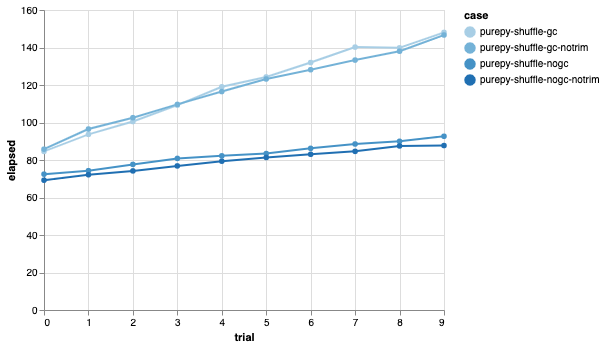

In [4]:
elapsed = alt.Chart(df.reset_index()).encode(x="trial", y="elapsed", color="case:O", tooltip=["case", "trial", "elapsed"]).mark_line(point=True)
elapsed

In [5]:
import dask

In [6]:
# cpu = df.iloc[:, 1:11]
cpu = df[["user", "system", "idle"]]
mem = (
#     df.iloc[:, 12:19]
    (df[["initial-rss", "initial-data", "initial-shared", "initial-text"]] / dask.utils.parse_bytes("1GiB"))
    .rename(columns=lambda c: c.replace("initial-", ""))
)

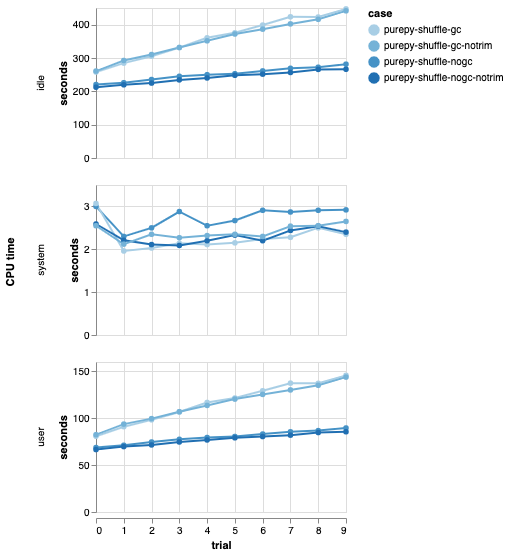

In [7]:
cpu_chart = (
    alt.Chart(
        cpu.melt(ignore_index=False, var_name="CPU time", value_name="seconds").reset_index(),
        height=150,
        width=250,
    )
    .encode(x="trial", y="seconds", color="case:O", row="CPU time", tooltip=["case", "seconds"])
    .mark_line(point=True)
    .resolve_scale(y='independent')
)
cpu_chart

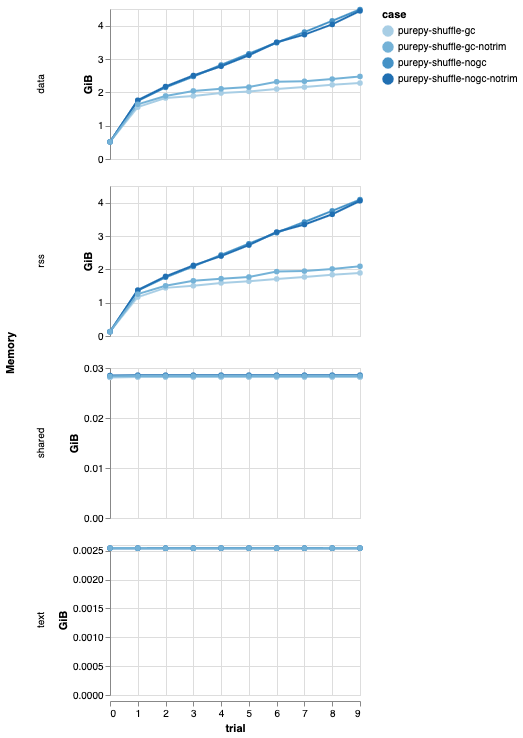

In [8]:
mem_chart = (
    alt.Chart(
        mem.melt(ignore_index=False, var_name="Memory", value_name="GiB").reset_index(),
        height=150,
        width=250,
    )
    .encode(x="trial", y="GiB", color="case:O", row="Memory", tooltip=["case", "GiB"])
    .mark_line(point=True)
    .resolve_scale(y='independent')
)
mem_chart

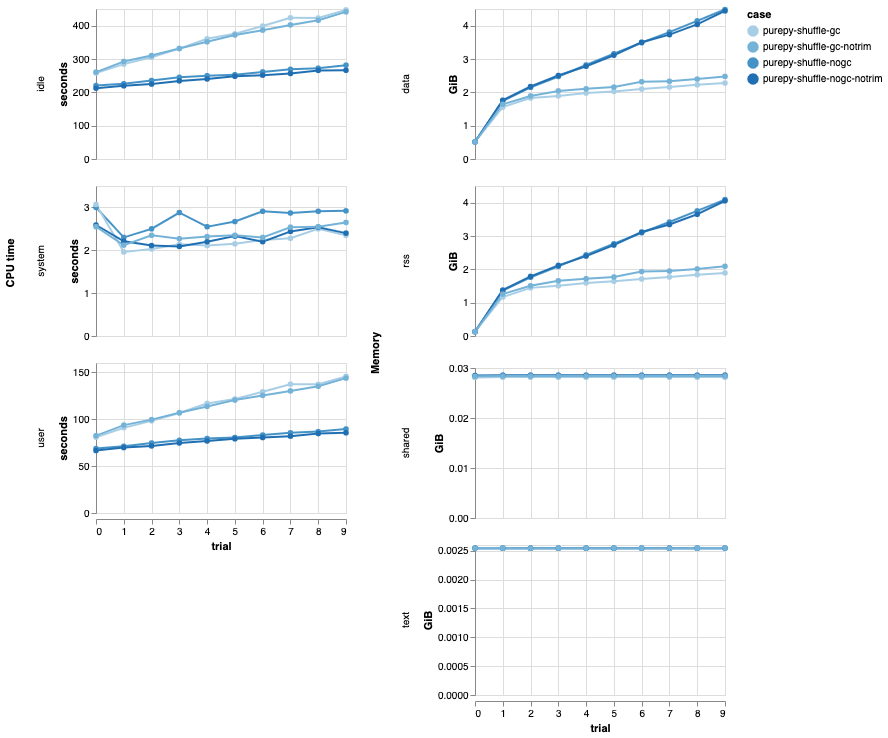

In [9]:
cpu_chart | mem_chart

In [10]:
def percent_improvement(before="purepy-shuffle-gc", after="purepy-shuffle-nogc", i_before=0, i_after=0):
    before = df["elapsed"].loc[(before, i_before)]
    after = df["elapsed"].loc[(after, i_after)]
    return -100 * (after - before) / before

In [11]:
percent_improvement()

14.347883279599023

In [12]:
percent_improvement(i_before=9, i_after=9)

37.42165551596856

In [13]:
percent_improvement(before="purepy-shuffle-gc", after="purepy-shuffle-gc", i_before=0, i_after=9)

-75.04486483568536